In [1]:
import os
from pathlib import Path
import sys
import numpy as np
import pandas as pd

# add parent directory to path for imports
current_dir = os.getcwd()
sys.path.insert(0, str(Path(current_dir).parent))
from configs.config import DERIVATIVES_DIR, TR

# specify subject, session, task, and run
SUBJECT_ID = 'sub-008'
SESSION_ID = 'ses-04'
TASK = 'tomloc'
RUN_NUM = 2

BOLD_PATH = str(DERIVATIVES_DIR / SUBJECT_ID / SESSION_ID / 'func' / f'{SUBJECT_ID}_{SESSION_ID}_task-{TASK + str(RUN_NUM)}_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz')

In [2]:
# load data and extract time series based on Schaefer atlas
from nilearn import datasets, image
from nilearn.maskers import NiftiLabelsMasker
from nilearn.interfaces.fmriprep import load_confounds

def extract_roi_time_series(bold_path, n_rois=400, yeo_networks=17):
    """Extract time series from Schaefer atlas ROIs"""
    # Load Schaefer atlas
    schaefer_atlas = datasets.fetch_atlas_schaefer_2018(
        n_rois=n_rois, 
        yeo_networks=yeo_networks,
        resolution_mm=2
    )
    
    # Create masker for ROI extraction
    masker = NiftiLabelsMasker(
        labels_img=schaefer_atlas['maps'],
        labels=schaefer_atlas['labels'],
        standardize='zscore_sample',
        memory='nilearn_cache',
        verbose=1
    )
    
    # Load confounds
    confounds, sample_mask = load_confounds(
        bold_path,
        strategy=["high_pass", "motion", "wm_csf", "global_signal"]
    )

    # Extract time series
    bold_img = image.load_img(bold_path)
    time_series = masker.fit_transform(bold_img, confounds=confounds)
    
    # Remove background label (first entry)
    roi_labels = schaefer_atlas['labels'][1:]  # Skip background
    
    return time_series, roi_labels

time_series, roi_labels = extract_roi_time_series(BOLD_PATH)
print(f'Extracted time series shape: {time_series.shape}')

[fetch_atlas_schaefer_2018] Dataset found in /Users/gioli/nilearn_data/schaefer_2018

[NiftiLabelsMasker.wrapped] Loading regions from 
'/Users/gioli/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2mm.nii.gz'

[NiftiLabelsMasker.wrapped] Resampling regions

[NiftiLabelsMasker.wrapped] Finished fit

________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x1523487d0>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x152541fd0>, { 'background_label': 0,
  'clean_args': None,
  'clean_kwargs': {},
  'cmap': 'CMRmap_r',
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': [ 'Background',
              '17Networks_LH_VisCent_ExStr_1',
              '17Networks_LH_VisCent_ExStr_2',
              '17Networks_LH_VisCent_ExStr_3',
              '17Networks_LH_VisCent_ExStr_4',
              '17Networks_LH_VisCent_ExStr_5',
              '17Networks_LH_VisCent_ExStr_6',
              '17Networks_LH_VisCent_Striate_1',
              '17Networks_LH_VisCent_ExStr_7',
              '17Networks_LH_VisCent_ExStr_8',
              '17Networks_LH_Vis.

[NiftiLabelsMasker.wrapped] Loading data from <nibabel.nifti1.Nifti1Image object at 0x1523487d0>

[NiftiLabelsMasker.wrapped] Extracting region signals

[NiftiLabelsMasker.wrapped] Cleaning extracted signals

_______________________________________________filter_and_extract - 6.7s, 0.1min
Extracted time series shape: (198, 400)


In [3]:
# generate events dataframe and construct design matrix
from utils import generate_events_dataframe
events_df, contrast = generate_events_dataframe(TASK, RUN_NUM)

from nilearn.glm.first_level import make_first_level_design_matrix
n_trs, n_rois = time_series.shape
frame_times = np.arange(n_trs) * TR
design_matrix = make_first_level_design_matrix(
    frame_times,
    events=events_df,
    hrf_model='glover',
    high_pass=0.01
)
print(f'Design matrix shape: {design_matrix.shape}')

Design matrix shape: (198, 8)


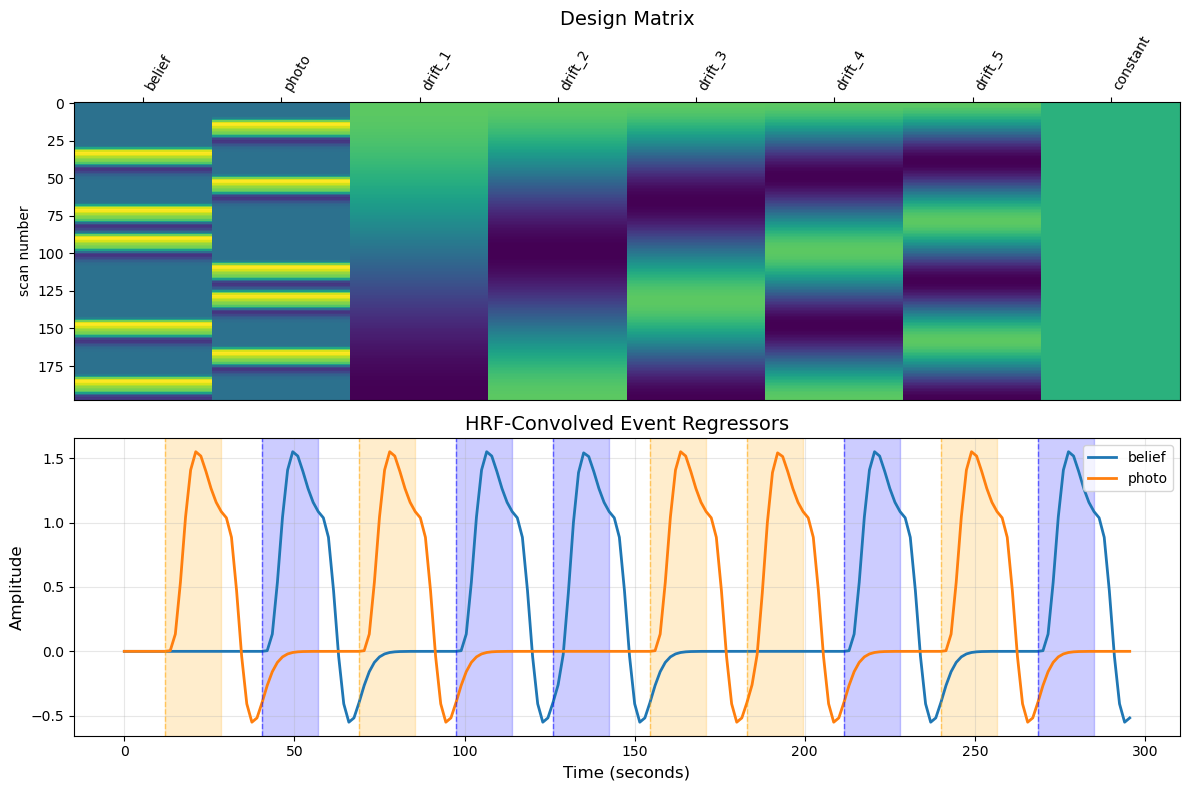

In [4]:
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Design matrix
plot_design_matrix(design_matrix, axes=axes[0])
axes[0].set_title('Design Matrix', fontsize=14)

# Plot 2: Event regressors with proper event overlays
# Get time axis in seconds
time_seconds = np.arange(len(design_matrix)) * TR

# Plot the HRF-convolved regressors
event_columns = [col for col in design_matrix.columns if col in events_df['trial_type'].unique()]
for col in event_columns:
    if col in design_matrix.columns:
        axes[1].plot(time_seconds, design_matrix[col], label=col, linewidth=2)

# Add event blocks with correct timing
for _, event in events_df.iterrows():
    color = 'blue' if event['trial_type'] == event_columns[0] else 'orange'
    axes[1].axvspan(event['onset'], event['onset'] + event['duration'], 
                    color=color, alpha=0.2, label=None)

# Add vertical lines at event onsets for clarity
for _, event in events_df.iterrows():
    color = 'blue' if event['trial_type'] == event_columns[0] else 'orange'
    axes[1].axvline(event['onset'], color=color, linestyle='--', alpha=0.5, linewidth=1)

axes[1].set_title('HRF-Convolved Event Regressors', fontsize=14)
axes[1].set_xlabel('Time (seconds)', fontsize=12)
axes[1].set_ylabel('Amplitude', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
# fit GLM and compute contrast
import statsmodels.api as sm

t_values = []
p_values = []

for roi in range(time_series.shape[1]):
    # Fit model
    model = sm.OLS(time_series[:, roi], design_matrix).fit()
    
    # Define contrast (adjust indices based on your design matrix)
    # Example: contrast between first two conditions
    contrast = [1, -1] + [0] * (len(design_matrix.columns) - 2)
    
    # Test contrast
    t_stat = model.t_test(contrast)
    t_values.append(t_stat.tvalue[0][0])
    p_values.append(t_stat.pvalue)

t_values = np.array(t_values)
p_values = np.array(p_values)

# Find significant ROIs
sig_rois_idx = np.where(p_values < 0.001)[0]
sig_rois = [roi_labels[i] for i in sig_rois_idx]
print(f"Significant ROIs: {sig_rois}")


Significant ROIs: ['17Networks_LH_VisPeri_ExStrSup_5', '17Networks_LH_SomMotA_8', '17Networks_LH_SomMotA_18', '17Networks_LH_DorsAttnA_ParOcc_1', '17Networks_LH_SalVentAttnA_Ins_4', '17Networks_LH_SalVentAttnA_FrOper_1', '17Networks_LH_SalVentAttnA_FrOper_2', '17Networks_LH_SalVentAttnA_ParMed_3', '17Networks_LH_SalVentAttnB_PFCl_1', '17Networks_LH_ContA_Temp_1', '17Networks_LH_ContB_Temp_1', '17Networks_LH_ContB_Temp_2', '17Networks_LH_ContC_pCun_3', '17Networks_LH_DefaultA_PFCd_2', '17Networks_LH_DefaultA_pCunPCC_2', '17Networks_LH_DefaultA_pCunPCC_3', '17Networks_LH_DefaultA_pCunPCC_6', '17Networks_LH_DefaultA_pCunPCC_7', '17Networks_LH_DefaultB_IPL_1', '17Networks_LH_DefaultB_PFCd_1', '17Networks_LH_DefaultB_PFCv_2', '17Networks_LH_TempPar_6', '17Networks_RH_DorsAttnA_ParOcc_2', '17Networks_RH_DorsAttnB_PostC_6', '17Networks_RH_SalVentAttnA_Ins_2', '17Networks_RH_LimbicA_TempPole_5', '17Networks_RH_ContA_PFCd_1', '17Networks_RH_ContA_PFCl_5', '17Networks_RH_ContB_IPL_1', '17Network

Top 6 ROIs by t-value:
--------------------------------------------------------------------------------
1. 17Networks_RH_DefaultA_IPL_1
   t-value: 11.680, p-value: 4.17e-24
2. 17Networks_RH_DefaultC_IPL_1
   t-value: 8.908, p-value: 4.20e-16
3. 17Networks_RH_TempPar_3
   t-value: 8.452, p-value: 7.40e-15
4. 17Networks_RH_DefaultB_Temp_1
   t-value: 8.268, p-value: 2.32e-14
5. 17Networks_RH_TempPar_9
   t-value: 8.235, p-value: 2.84e-14
6. 17Networks_RH_ContC_pCun_3
   t-value: 7.803, p-value: 3.94e-13
--------------------------------------------------------------------------------


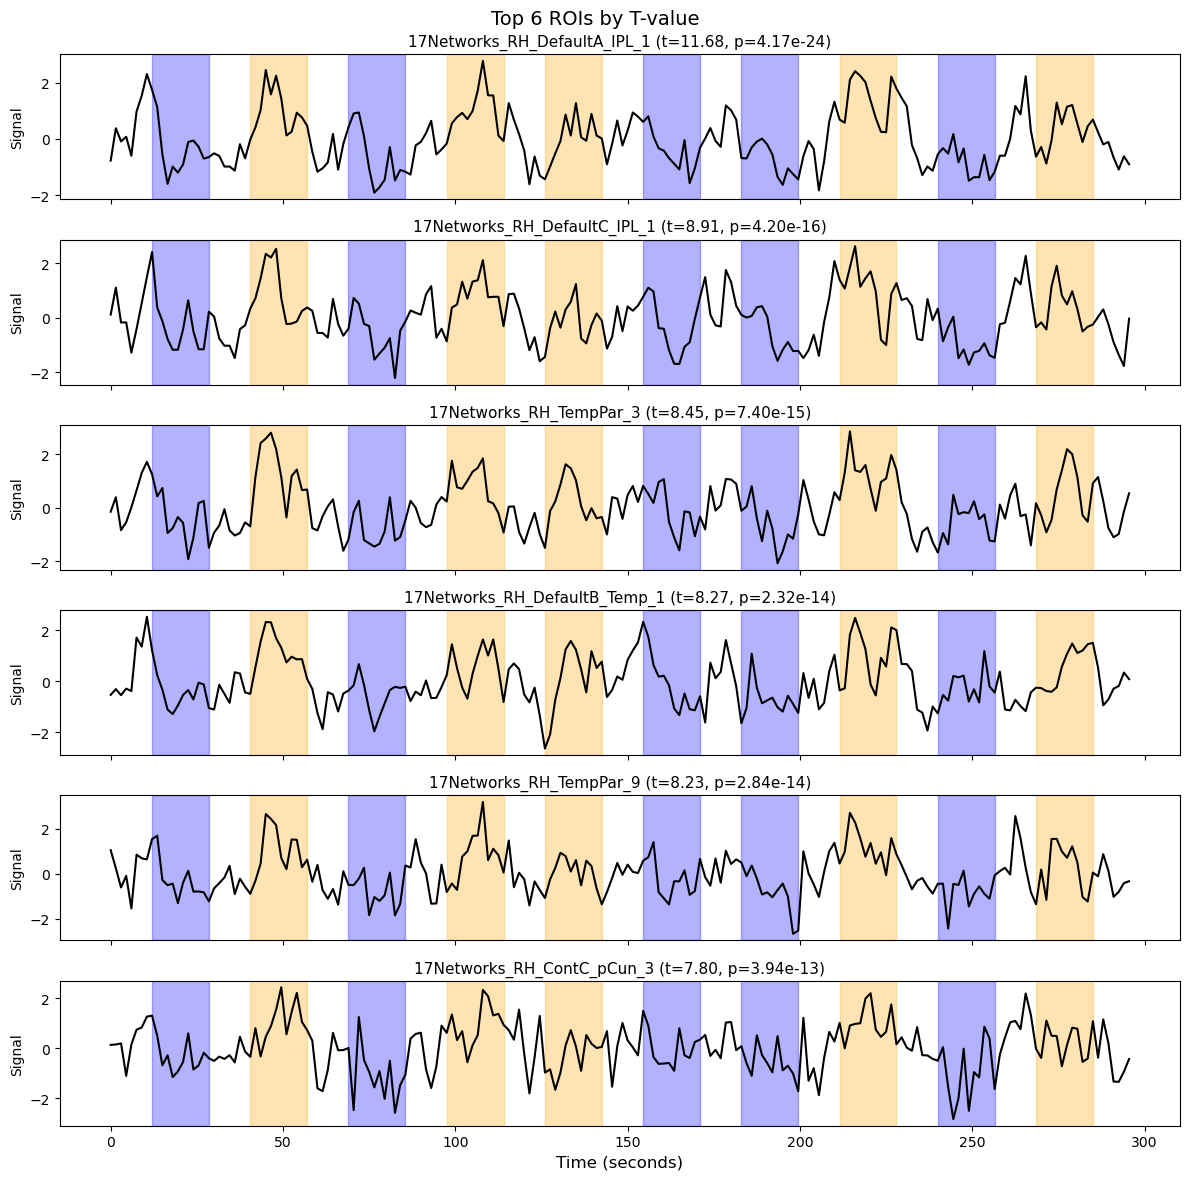

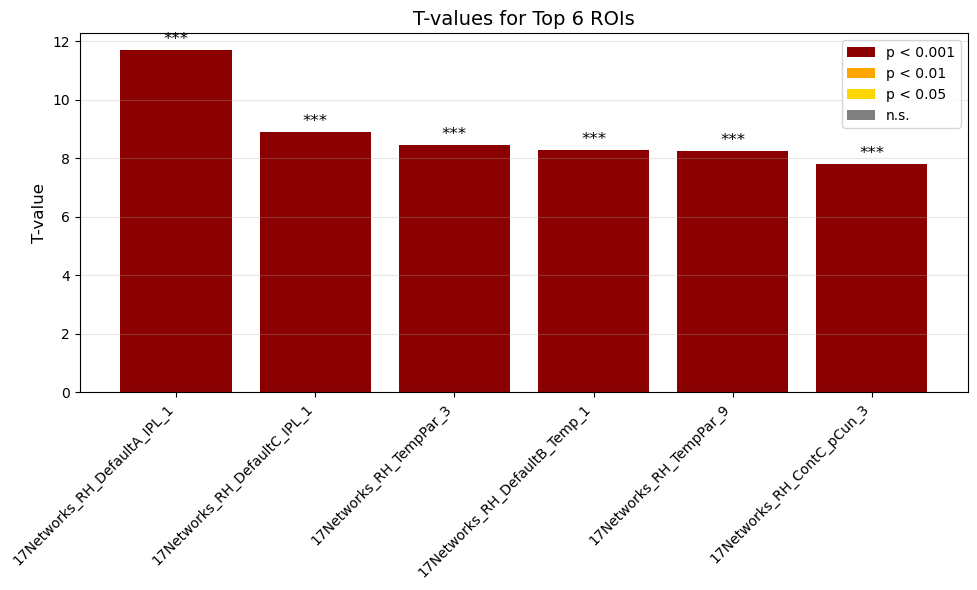

In [6]:
# Find top 6 ROIs by t-value
top_n = 6
top_indices = np.argsort(t_values)[::-1][:top_n]
top_labels = [roi_labels[i] for i in top_indices]
top_tvalues = t_values[top_indices]
top_pvalues = p_values[top_indices]

# Print summary of top ROIs
print(f"Top {top_n} ROIs by t-value:")
print("-" * 80)
for i, (idx, label, tval, pval) in enumerate(zip(top_indices, top_labels, top_tvalues, top_pvalues)):
    print(f"{i+1}. {label}")
    print(f"   t-value: {tval:.3f}, p-value: {pval:.2e}")
print("-" * 80)

# Plot time series for top ROIs
fig, axes = plt.subplots(top_n, 1, figsize=(12, 2*top_n), sharex=True)
time_seconds = np.arange(time_series.shape[0]) * TR

for idx, roi_idx in enumerate(top_indices):
    # Plot ROI time series
    axes[idx].plot(time_seconds, time_series[:, roi_idx], 'k-', linewidth=1.5)
    
    # Add event blocks if events_df exists
    if 'events_df' in locals():
        for _, event in events_df.iterrows():
            color = 'blue' if event['trial_type'] == events_df['trial_type'].unique()[0] else 'orange'
            axes[idx].axvspan(event['onset'], event['onset'] + event['duration'], 
                             color=color, alpha=0.3)
    
    axes[idx].set_ylabel('Signal', fontsize=10)
    axes[idx].set_title(f'{top_labels[idx]} (t={top_tvalues[idx]:.2f}, p={top_pvalues[idx]:.2e})', fontsize=11)

axes[-1].set_xlabel('Time (seconds)', fontsize=12)
plt.suptitle(f'Top {top_n} ROIs by T-value', fontsize=14)
plt.tight_layout()
plt.show()

# Create a bar plot of t-values for top ROIs
plt.figure(figsize=(10, 6))
colors = ['darkred' if p < 0.001 else 'orange' if p < 0.01 else 'gold' if p < 0.05 else 'gray' 
          for p in top_pvalues]
bars = plt.bar(range(top_n), top_tvalues, color=colors)

# Add significance stars
for i, (bar, pval) in enumerate(zip(bars, top_pvalues)):
    if pval < 0.001:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, '***', 
                ha='center', va='bottom', fontsize=12)
    elif pval < 0.01:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, '**', 
                ha='center', va='bottom', fontsize=12)
    elif pval < 0.05:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, '*', 
                ha='center', va='bottom', fontsize=12)

plt.xticks(range(top_n), [f"{top_labels[i]}" for i in range(top_n)], rotation=45, ha='right')
plt.ylabel('T-value', fontsize=12)
plt.title(f'T-values for Top {top_n} ROIs', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# Add legend for significance levels
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='darkred', label='p < 0.001'),
    Patch(facecolor='orange', label='p < 0.01'),
    Patch(facecolor='gold', label='p < 0.05'),
    Patch(facecolor='gray', label='n.s.')
]
plt.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()

Found 74 ROIs containing 'PFC'
Top ROIs: ['17Networks_RH_DefaultB_PFCd_4', '17Networks_RH_DefaultA_PFCd_2', '17Networks_RH_DefaultA_PFCm_5', '17Networks_RH_ContA_PFCd_1', '17Networks_RH_ContA_PFCl_5', '17Networks_RH_DefaultB_PFCd_1']


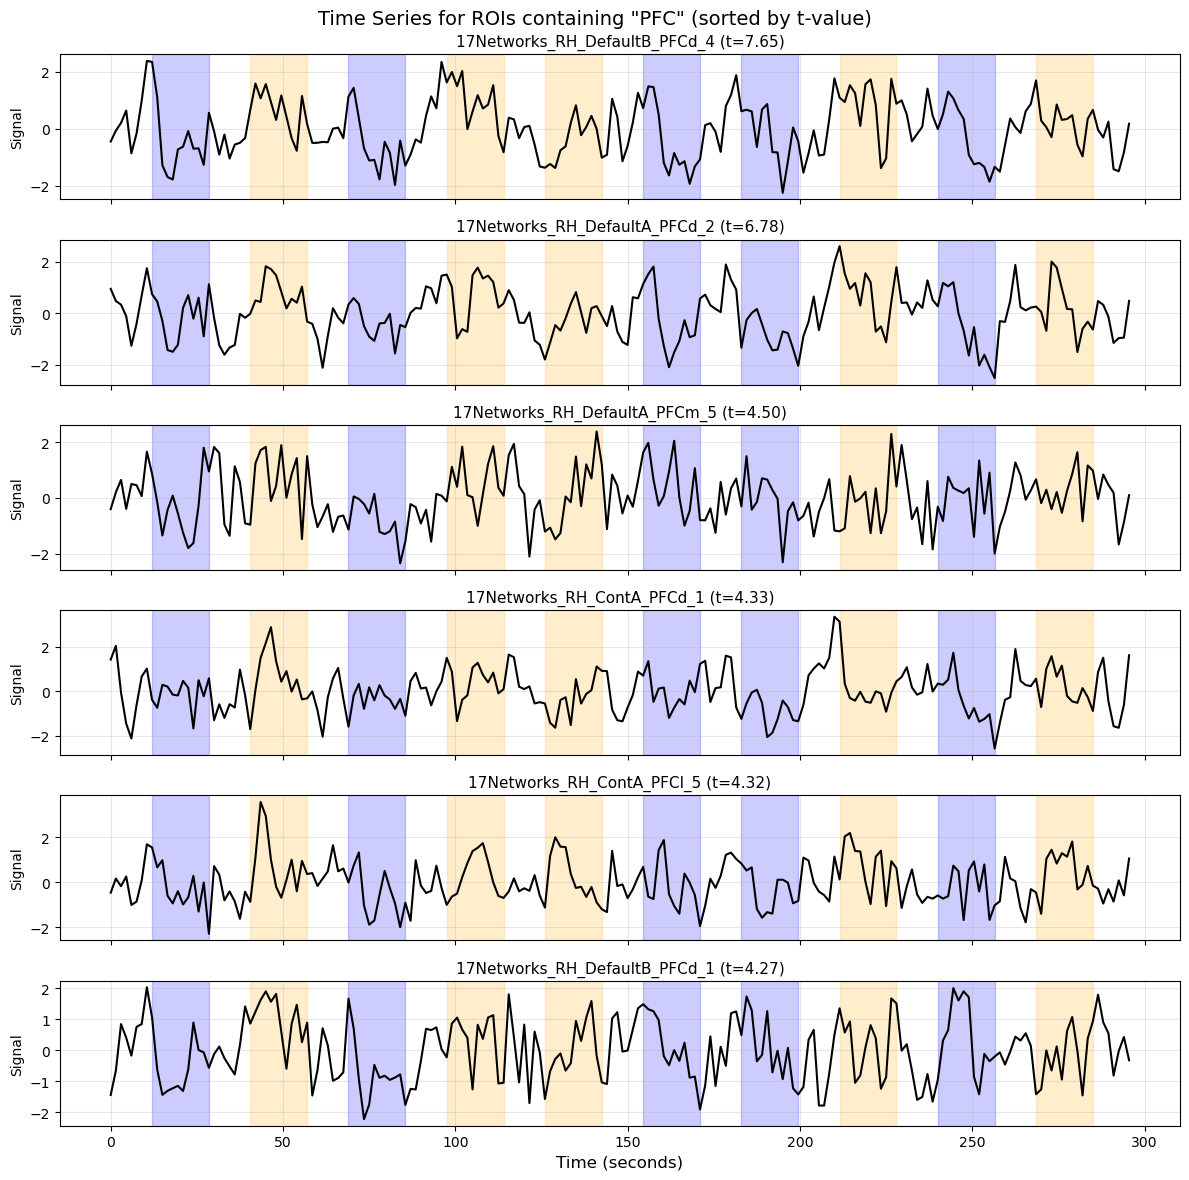

In [7]:
# Search for ROIs with specific keyword
keyword = 'PFC'  # Change this to search for different ROIs (e.g., 'ContB', 'TPJ', 'Default')

# Find matching ROIs
matching_indices = []
matching_labels = []
matching_tvalues = []
for i, label in enumerate(roi_labels):
    if keyword in label:
        matching_indices.append(i)
        matching_labels.append(label)
        matching_tvalues.append(t_values[i])

# Sort by t-values (descending)
sorted_idx = np.argsort(matching_tvalues)[::-1]
matching_indices = [matching_indices[i] for i in sorted_idx]
matching_labels = [matching_labels[i] for i in sorted_idx]
matching_tvalues = [matching_tvalues[i] for i in sorted_idx]

print(f"Found {len(matching_indices)} ROIs containing '{keyword}'")
print(f"Top ROIs: {matching_labels[:6]}")

# Plot time series for matching ROIs (limit to first 6 for clarity)
n_plots = min(len(matching_indices), 6)
fig, axes = plt.subplots(n_plots, 1, figsize=(12, 2*n_plots), sharex=True)
if n_plots == 1:
    axes = [axes]

time_seconds = np.arange(time_series.shape[0]) * TR

for idx, roi_idx in enumerate(matching_indices[:n_plots]):
    # Plot ROI time series
    axes[idx].plot(time_seconds, time_series[:, roi_idx], 'k-', linewidth=1.5)
    
    # Add event blocks if events_df exists
    if 'events_df' in locals():
        for _, event in events_df.iterrows():
            color = 'blue' if event['trial_type'] == events_df['trial_type'].unique()[0] else 'orange'
            axes[idx].axvspan(event['onset'], event['onset'] + event['duration'], 
                             color=color, alpha=0.2)
    
    axes[idx].set_ylabel('Signal', fontsize=10)
    axes[idx].set_title(f'{matching_labels[idx]} (t={matching_tvalues[idx]:.2f})', fontsize=11)
    axes[idx].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (seconds)', fontsize=12)
plt.suptitle(f'Time Series for ROIs containing "{keyword}" (sorted by t-value)', fontsize=14)
plt.tight_layout()
plt.show()

FDR q < 0.05 corresponds to |t| > 2.522


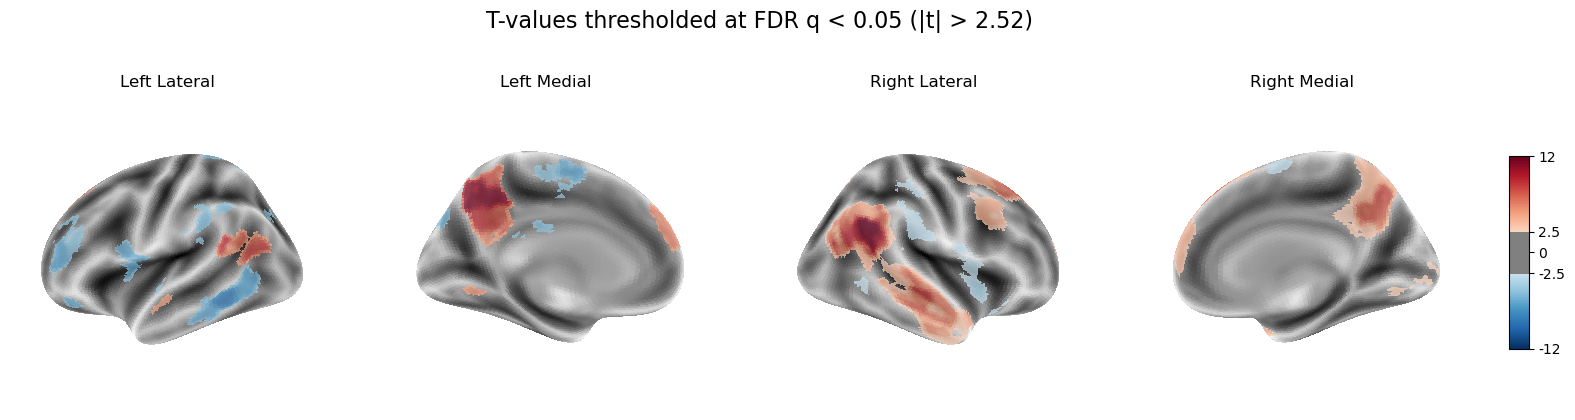

In [13]:
from statsmodels.stats.multitest import multipletests
from nilearn import datasets, plotting, image, surface
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

# Apply FDR correction
rejected, q_values, alpha_sidak, alpha_bonf = multipletests(
    p_values, alpha=0.05, method='fdr_bh'
)

# Find the t-value threshold that corresponds to FDR q = 0.05
if np.any(rejected):
    significant_t_values = np.abs(t_values[rejected])
    t_threshold_fdr = np.min(significant_t_values)
    print(f"FDR q < 0.05 corresponds to |t| > {t_threshold_fdr:.3f}")
else:
    t_threshold_fdr = np.max(np.abs(t_values)) + 1
    print("No ROIs survive FDR correction at q < 0.05")

# Create the t-value map
t_map_data = np.zeros_like(atlas_data)
for roi_idx in range(len(t_values)):
    roi_mask = atlas_data == roi_idx + 1
    t_map_data[roi_mask] = t_values[roi_idx]

t_map_img = image.new_img_like(atlas_img, t_map_data)

# Fetch fsaverage surface meshes
fsaverage = datasets.fetch_surf_fsaverage()

# Project volume data to surface
texture_left = surface.vol_to_surf(t_map_img, fsaverage.pial_left)
texture_right = surface.vol_to_surf(t_map_img, fsaverage.pial_right)

# Create 1x4 subplot figure with adjusted spacing
fig, axes = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': '3d'})
fig.suptitle(f'T-values thresholded at FDR q < 0.05 (|t| > {t_threshold_fdr:.2f})', fontsize=16)

# Left lateral
plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture_left,
    hemi='left', view='lateral',
    title='Left Lateral', colorbar=False,
    threshold=t_threshold_fdr,
    axes=axes[0],
    bg_map=fsaverage.sulc_left,
    cmap='RdBu_r',
    symmetric_cbar=True,
    bg_on_data=True,
    darkness=None
)

# Left medial
plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture_left,
    hemi='left', view='medial',
    title='Left Medial', colorbar=False,
    threshold=t_threshold_fdr,
    axes=axes[1],
    bg_map=fsaverage.sulc_left,
    cmap='RdBu_r',
    symmetric_cbar=True,
    bg_on_data=True,
    darkness=None
)

# Right lateral
plotting.plot_surf_stat_map(
    fsaverage.infl_right, texture_right,
    hemi='right', view='lateral',
    title='Right Lateral', colorbar=False,
    threshold=t_threshold_fdr,
    axes=axes[2],
    bg_map=fsaverage.sulc_right,
    cmap='RdBu_r',
    symmetric_cbar=True,
    bg_on_data=True,
    darkness=None
)

# Right medial
plotting.plot_surf_stat_map(
    fsaverage.infl_right, texture_right,
    hemi='right', view='medial',
    title='Right Medial', colorbar=True,
    threshold=t_threshold_fdr,
    axes=axes[3],
    bg_map=fsaverage.sulc_right,
    cmap='RdBu_r',
    symmetric_cbar=True,
    bg_on_data=True,
    darkness=None
)

# Adjust layout to make room for colorbar
plt.subplots_adjust(right=0.85)  # Leave space on the right for colorbar
plt.show()